In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

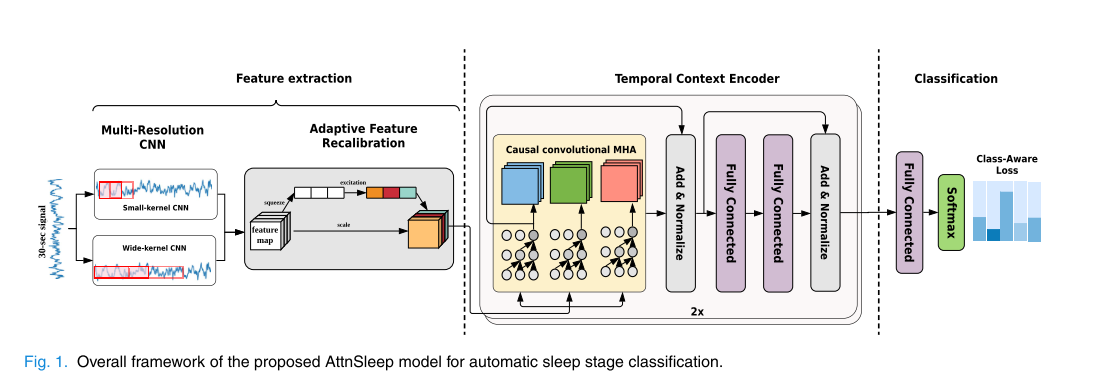

In [2]:
writer = SummaryWriter()

In [3]:
train_set = pd.read_csv("data/final_format/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/final_format/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/final_format/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/final_format/test_label.csv",header=None).to_numpy()

In [4]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14393, 4096) (14393, 1) (3599, 4096) (3599, 1)


In [5]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 4096) (14392, 1) (3598, 4096) (3598, 1)


In [6]:
train_set = train_set.reshape((-1,1,64,64))
test_set = test_set.reshape((-1,1,64,64))
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 64, 64) (14392, 1) (3598, 64, 64) (3598, 1)


In [7]:
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 64, 64) (14392,) (3598, 64, 64) (3598,)


In [8]:
# Hyper parameters
num_epochs = 300
num_classes = 4
batch_size = 64
learning_rate = 1e-3

In [9]:
train_set_tensor = Tensor(train_set) 
train_label_tensor = Tensor(train_label).type(torch.LongTensor)

train_dataset = TensorDataset(train_set_tensor,train_label_tensor) 
train_loader = DataLoader(train_dataset, batch_size=batch_size) 

test_set_tensor = Tensor(test_set) 
test_label_tensor = Tensor(test_label).type(torch.LongTensor)

test_dataset = TensorDataset(test_set_tensor,test_label_tensor) 
test_loader = DataLoader(test_dataset, batch_size=batch_size) 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [2]:
class SleepStagerEldele2021(nn.Module):
    """Sleep Staging Architecture from Eldele et al 2021.

    Attention based Neural Net for sleep staging as described in [Eldele2021]_.
    The code for the paper and this model is also available at [1]_.
    Takes single channel EEG as input.
    Feature extraction module based on multi-resolution convolutional neural network (MRCNN)
    and adaptive feature recalibration (AFR).
    The second module is the temporal context encoder (TCE) that leverages a multi-head attention
    mechanism to capture the temporal dependencies among the extracted features.

    Warning - This model was designed for signals of 30 seconds at 100Hz or 125Hz (in which case
    the reference architecture from [1]_ which was validated on SHHS dataset [2]_ will be used)
    to use any other input is likely to make the model perform in unintended ways.

    Parameters
    ----------
    sfreq : float
        EEG sampling frequency.
    n_tce : int
        Number of TCE clones.
    d_model : int
        Input dimension for the TCE.
        Also the input dimension of the first FC layer in the feed forward
        and the output of the second FC layer in the same.
        Increase for higher sampling rate/signal length.
        It should be divisible by n_attn_heads
    d_ff : int
        Output dimension of the first FC layer in the feed forward and the
        input dimension of the second FC layer in the same.
    n_attn_heads : int
        Number of attention heads. It should be a factor of d_model
    dropout : float
        Dropout rate in the PositionWiseFeedforward layer and the TCE layers.
    input_size_s : float
        Size of the input, in seconds.
    n_classes : int
        Number of classes.
    after_reduced_cnn_size : int
        Number of output channels produced by the convolution in the AFR module.
    return_feats : bool
        If True, return the features, i.e. the output of the feature extractor
        (before the final linear layer). If False, pass the features through
        the final linear layer.

    References
    ----------
    .. [Eldele2021] E. Eldele et al., "An Attention-Based Deep Learning Approach for Sleep Stage
        Classification With Single-Channel EEG," in IEEE Transactions on Neural Systems and
        Rehabilitation Engineering, vol. 29, pp. 809-818, 2021, doi: 10.1109/TNSRE.2021.3076234.

    .. [1] https://github.com/emadeldeen24/AttnSleep

    .. [2] https://sleepdata.org/datasets/shhs
    """

    def __init__(self, sfreq=160, n_tce=2, d_model=80, d_ff=120, n_attn_heads=5, dropout=0.1,
                 input_size_s=0.5, n_classes=4, after_reduced_cnn_size=30, return_feats=False):
        super(SleepStagerEldele2021, self).__init__()

        input_size = np.ceil(input_size_s * sfreq).astype(int)

        if not ((input_size_s == 30 and sfreq == 100 and d_model == 80) or
                (input_size_s == 30 and sfreq == 125 and d_model == 100)):
            warnings.warn("This model was designed originally for input windows of 30sec at 100Hz, "
                          "with d_model at 80 or at 125Hz, with d_model at 100, to use anything "
                          "other than this may cause errors or cause the model to perform in "
                          "other ways than intended", UserWarning)

        # the usual kernel size for the mrcnn, for sfreq 100
        kernel_size = 7

        if sfreq == 125:
            kernel_size = 6

        mrcnn = _MRCNN(after_reduced_cnn_size, kernel_size)
        attn = _MultiHeadedAttention(n_attn_heads, d_model, after_reduced_cnn_size)
        ff = _PositionwiseFeedForward(d_model, d_ff, dropout)
        tce = _TCE(_EncoderLayer(d_model, deepcopy(attn), deepcopy(ff), after_reduced_cnn_size,
                                 dropout), n_tce)

        self.feature_extractor = nn.Sequential(mrcnn, tce)
        self.len_last_layer = self._len_last_layer(input_size)
        self.return_feats = return_feats
        if not return_feats:
            self.fc = nn.Linear(d_model * after_reduced_cnn_size, n_classes)

    def _len_last_layer(self, input_size):
        self.feature_extractor.eval()
        with torch.no_grad():
            out = self.feature_extractor(torch.Tensor(1, 1, input_size))
        self.feature_extractor.train()
        return len(out.flatten())

    def forward(self, x):
        """
        Forward pass.

        Parameters
        ----------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """

        encoded_features = self.feature_extractor(x)
        encoded_features = encoded_features.contiguous().view(encoded_features.shape[0], -1)

        if self.return_feats:
            return encoded_features
        else:
            final_output = self.fc(encoded_features)
            return final_output


class _SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(_SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class _SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(_SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, 1)
        self.bn2 = nn.BatchNorm1d(planes)
        self.se = _SELayer(planes, reduction)
        self.downsample = downsample
        self.stride = stride
        self.features = nn.Sequential(self.conv1, self.bn1, self.relu, self.conv2, self.bn2,
                                      self.se)

    def forward(self, x):
        residual = x
        out = self.features(x)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class _MRCNN(nn.Module):
    def __init__(self, after_reduced_cnn_size, kernel_size=7):
        super(_MRCNN, self).__init__()
        drate = 0.5
        self.GELU = nn.GELU()
        self.features1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=50, stride=6, bias=False, padding=24),
            nn.BatchNorm1d(64),
            self.GELU,
            nn.MaxPool1d(kernel_size=8, stride=2, padding=4),
            nn.Dropout(drate),

            nn.Conv1d(64, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            self.GELU,

            nn.Conv1d(128, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            self.GELU,

            nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        )

        self.features2 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=400, stride=50, bias=False, padding=200),
            nn.BatchNorm1d(64),
            self.GELU,
            nn.MaxPool1d(kernel_size=4, stride=2, padding=2),
            nn.Dropout(drate),

            nn.Conv1d(64, 128, kernel_size=kernel_size, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            self.GELU,

            nn.Conv1d(128, 128, kernel_size=kernel_size, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            self.GELU,

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.dropout = nn.Dropout(drate)
        self.inplanes = 128
        self.AFR = self._make_layer(_SEBasicBlock, after_reduced_cnn_size, 1)

    def _make_layer(self, block, planes, blocks, stride=1):  # makes residual SE block
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x1 = self.features1(x)
        x2 = self.features2(x)
        x_concat = torch.cat((x1, x2), dim=2)
        x_concat = self.dropout(x_concat)
        x_concat = self.AFR(x_concat)
        return x_concat


##########################################################################################


def _attention(query, key, value, dropout=None):
    """Implementation of Scaled dot product attention"""
    # d_k - dimension of the query and key vectors
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class _CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(_CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias)

    def forward(self, input):
        result = super(_CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[:, :, :-self.__padding]
        return result


class _MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, after_reduced_cnn_size, dropout=0.1):
        """Take in model size and number of heads."""
        super(_MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_per_head = d_model // h
        self.h = h

        self.convs = _clones(_CausalConv1d(after_reduced_cnn_size, after_reduced_cnn_size,
                                           kernel_size=7, stride=1), 3)
        self.linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        """Implements Multi-head attention"""
        nbatches = query.size(0)

        query = query.view(nbatches, -1, self.h, self.d_per_head).transpose(1, 2)
        key = self.convs[1](key).view(nbatches, -1, self.h, self.d_per_head).transpose(1, 2)
        value = self.convs[2](value).view(nbatches, -1, self.h, self.d_per_head).transpose(1, 2)

        x, self.attn = _attention(query, key, value, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous() \
            .view(nbatches, -1, self.h * self.d_per_head)

        return self.linear(x)


class _SublayerOutput(nn.Module):
    """
    A residual connection followed by a layer norm.
    """

    def __init__(self, size, dropout):
        super(_SublayerOutput, self).__init__()
        self.norm = nn.LayerNorm(size, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Apply residual connection to any sublayer with the same size."""
        return x + self.dropout(sublayer(self.norm(x)))


def _clones(module, n):
    """Produce n identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(n)])


class _TCE(nn.Module):
    """
    Transformer Encoder
    It is a stack of n layers.
    """

    def __init__(self, layer, n):
        super(_TCE, self).__init__()
        self.layers = _clones(layer, n)
        self.norm = nn.LayerNorm(layer.size, eps=1e-6)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)


class _EncoderLayer(nn.Module):
    """
    An encoder layer
    Made up of self-attention and a feed forward layer.
    Each of these sublayers have residual and layer norm, implemented by _SublayerOutput.
    """

    def __init__(self, size, self_attn, feed_forward, after_reduced_cnn_size, dropout):
        super(_EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = _clones(_SublayerOutput(size, dropout), 2)
        self.size = size
        self.conv = _CausalConv1d(after_reduced_cnn_size, after_reduced_cnn_size, kernel_size=7,
                                  stride=1, dilation=1)

    def forward(self, x_in):
        """Transformer Encoder"""
        query = self.conv(x_in)
        # Encoder self-attention
        x = self.sublayer_output[0](query, lambda x: self.self_attn(query, x_in, x_in))
        return self.sublayer_output[1](x, self.feed_forward)


class _PositionwiseFeedForward(nn.Module):
    """Positionwise feed-forward network."""

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(_PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """Implements FFN equation."""
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [3]:
model = SleepStagerEldele2021()
a = torch.randn((64,1,64,64))
b = model(a)
b.shape

NameError: name 'warnings' is not defined

In [12]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [13]:
model = SleepStagerChambon2018().to(device)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3) 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
milestones = [50,100,150,200,250]
milestones = [a * len(train_loader) for a in milestones]
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.5)

In [15]:

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct=0
    total=0
    running_loss = 0
    for i, (X, Y) in enumerate(train_loader):
        X = X.to(device)
        Y = Y.to(device)


        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #scheduler.step() 
        #print(scheduler.get_last_lr()[0])

        optimizer.step()
        scheduler.step() 
        #print(optimizer.param_groups[0]["lr"])

        _, predicted = outputs.max(1)
        total += Y.size(0)
        correct += predicted.eq(Y).sum().item()
        running_loss += loss.item()
        accu=100.*correct/total
        train_loss = running_loss/(i+1)
        print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}%, Training Loss: {:.4f}%'.format(epoch+1, num_epochs, i+1, total_step, accu, train_loss))


        #writer.add_scalar(f'train/accuracy', accu, epoch)
        #writer.add_scalar(f'train/loss', train_loss, epoch)
        writer.add_scalars(f'train/accuracy_loss', {
            'accuracy': accu,
            'loss': train_loss,
        }, epoch)
        
        

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 1, 64, 1], but got 3-dimensional input of size [64, 64, 64] instead

In [ ]:

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

    print('Test Accuracy : {} %'.format(100 * correct / total))

# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')

In [ ]:
#for i in range(10):
#    x = all_data[i]
#    y = all_label[all-i]